## 0. Setup

In [1]:
# Import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
from plot_lib import plot_data, plot_model, set_default

In [3]:
set_default()

In [4]:
# Set up your device 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [5]:
# Set up random seed to 1008. Do not change the random seed.
seed = 1008
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed_all(seed)

## 1. Data: MNIST
#### Load the MNIST training and test dataset using $\texttt{torch.utils.data.DataLoader}$ and $\texttt{torchvision.datasets}$. 

Hint: You might find Alf's notebook useful: https://github.com/Atcold/pytorch-Deep-Learning-Minicourse/blob/master/06-convnet.ipynb

### 1.1. Load Training Set [4 pts]

In [6]:
# Load the MNIST training set with batch size 128, apply data shuffling and normalization
# train_loader = TODO
batch_size=128
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

In [7]:
perm=torch.arange(0, 784).long()
for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        print(data.shape)
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        print(data.shape)
        break

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


In [8]:
m = torch.rand([128, 50, 4, 4])
m = m.view(-1, 50*4*4)
m.shape

torch.Size([128, 800])

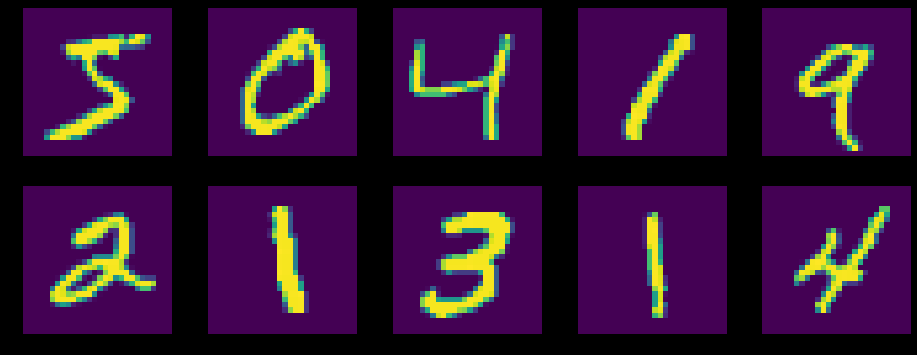

In [9]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

### 1.1. Load Test Set [4 pts]

In [10]:
# Load the MNIST test set with batch size 128, apply data shuffling and normalization
# test_loader = TODO
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

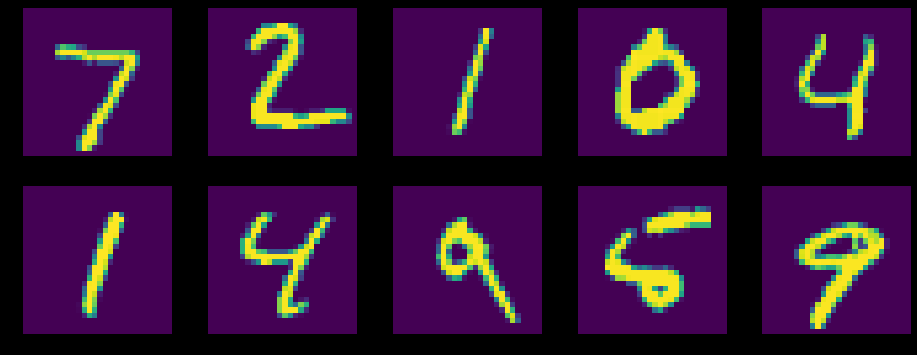

In [11]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = test_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

## 2. Models
#### You are going to define two convolutional neural networks which are trained to classify MNIST digits

### 2.1. CNN without Batch Norm [15 pts]

In [12]:
# Fill in the values below that make this network valid for MNIST data

# conv1_in_ch = TODO
# conv2_in_ch = TODO
# fc1_in_features = TODO
# fc2_in_features = TODO
# n_classes = TODO
conv1_in_ch = 1
conv2_in_ch = 20
fc1_in_features = 800
fc2_in_features = 500
n_classes = 10

In [13]:
class NetWithoutBatchNorm(nn.Module):
    def __init__(self):
        super(NetWithoutBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=conv1_in_ch, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=conv2_in_ch, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=fc1_in_features, out_features=500)
        self.fc2 = nn.Linear(in_features=fc2_in_features, out_features=n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        print('conv1.{}'.format(x.shape))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        print('pool1.{}'.format(x.shape))
        x = F.relu(self.conv2(x))
        print('conv2.{}'.format(x.shape))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        print('pool2.{}'.format(x.shape))
        x = x.view(-1, fc1_in_features) # reshaping
        print('reshape.{}'.format(x.shape))
        x = F.relu(self.fc1(x))
        print('fc1.{}'.format(x.shape))
        x = self.fc2(x)
        print('fc2.{}'.format(x.shape))
        # Return the log_softmax of x.
        x = F.log_softmax(x, dim=1)
        print('out.{}'.format(x.shape))
        return x

### 2.2. CNN with Batch Norm [15 pts]

In [14]:
# Fill in the values below that make this network valid for MNIST data

# conv1_bn_size = TODO
# conv2_bn_size = TODO
# fc1_bn_size = TODO
conv1_bn_size = 20
conv2_bn_size = 50
fc1_bn_size = 500

In [15]:
# Define the CNN with architecture explained in Part 2.2
class NetWithBatchNorm(nn.Module):
    def __init__(self):
        super(NetWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=conv1_in_ch, out_channels=20, kernel_size=5, stride=1)
        self.conv1_bn = nn.BatchNorm2d(conv1_bn_size)
        self.conv2 = nn.Conv2d(in_channels=conv2_in_ch, out_channels=50, kernel_size=5, stride=1)
        self.conv2_bn = nn.BatchNorm2d(conv2_bn_size)
        self.fc1 = nn.Linear(in_features=fc1_in_features, out_features=500)
        self.fc1_bn = nn.BatchNorm1d(fc1_bn_size)
        self.fc2 = nn.Linear(in_features=fc2_in_features, out_features=n_classes)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, fc1_in_features)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## 3. Training & Evaluation

### 3.1. Define training method [15 pts]

In [16]:
def train(model, device, train_loader, optimizer, epoch, log_interval = 100):
    # Set model to training mode
    model.train()
    # Loop through data points
    for batch_idx, (data, target) in enumerate(train_loader):
        #pass # remove once implemented
    
        # Send data and target to device
        # TODO
        data, target = data.to(device), target.to(device)

        # Zero out the optimizer
        # TODO
        optimizer.zero_grad()
        
        # Pass data through model
        # TODO
        output = model(data)
        
        # Compute the negative log likelihood loss
        # TODO
        loss = F.nll_loss(output, target)
        
        # Backpropagate loss
        # TODO
        loss.backward(retain_graph=True)
        
        # Make a step with the optimizer
        # TODO
        optimizer.step()
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        # Print loss (uncomment lines below once implemented)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

### 3.2. Define test method [15 pts]

In [17]:
# Define test method
def test(model, device, test_loader):
    # Set model to evaluation mode
    model.eval()
    
    # Variable for the total loss 
    test_loss = 0
    # Counter for the correct predictions
    num_correct = 0
    
    with torch.no_grad():
        
        # Loop through data points
        for data, target in test_loader:
            #pass # remove once implemented
        
            # Send data to device
            # TODO
            data, target = data.to(device), target.to(device)
            
            # Pass data through model
            # TODO 
            output = model(data)
            
            # Compute the negative log likelihood loss with reduction='sum' and add to total test_loss
            # TODO
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
            
            # Get predictions from the model for each data point
            # TODO 
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
            
            # Add number of correct predictions to total num_correct 
            # TODO
            num_correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    # Compute the average test_loss
    # avg_test_loss = TODO
    avg_test_loss = test_loss / len(test_loader.dataset)
    
    # Print loss (uncomment lines below once implemented)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_test_loss, num_correct, len(test_loader.dataset),
        100. * num_correct / len(test_loader.dataset)))

### 3.3 Train NetWithoutBatchNorm() [5 pts]

In [18]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [20]:
# Define model and sent to device
# model = TODO
model = NetWithoutBatchNorm()
model.to(device)

# Optimizer: SGD with learning rate of 1e-2 and momentum of 0.5
# optimizer = TODO
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#print('Number of parameters: {}'.format(get_n_params(model)))

# Training loop with 10 epochs
for epoch in range(1, 10 + 1):
    #pass # remove once implemented

    # Train model
    # TODO
    train(model, device, train_loader, optimizer, epoch, log_interval = 100)
    
    # Test model
    # TODO
    test(model, device, test_loader)

conv1.torch.Size([128, 20, 24, 24])
pool1.torch.Size([128, 20, 12, 12])
conv2.torch.Size([128, 50, 8, 8])
pool2.torch.Size([128, 50, 4, 4])
reshape.torch.Size([128, 800])
fc1.torch.Size([128, 500])
fc2.torch.Size([128, 10])
out.torch.Size([128, 10])
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302849
conv1.torch.Size([128, 20, 24, 24])
pool1.torch.Size([128, 20, 12, 12])
conv2.torch.Size([128, 50, 8, 8])
pool2.torch.Size([128, 50, 4, 4])
reshape.torch.Size([128, 800])
fc1.torch.Size([128, 500])
fc2.torch.Size([128, 10])
out.torch.Size([128, 10])
conv1.torch.Size([128, 20, 24, 24])
pool1.torch.Size([128, 20, 12, 12])
conv2.torch.Size([128, 50, 8, 8])
pool2.torch.Size([128, 50, 4, 4])
reshape.torch.Size([128, 800])
fc1.torch.Size([128, 500])
fc2.torch.Size([128, 10])
out.torch.Size([128, 10])
conv1.torch.Size([128, 20, 24, 24])
pool1.torch.Size([128, 20, 12, 12])
conv2.torch.Size([128, 50, 8, 8])
pool2.torch.Size([128, 50, 4, 4])
reshape.torch.Size([128, 800])
fc1.torch.Size([128, 500])
fc2.tor

KeyboardInterrupt: 

### 3.4 Train NetWithBatchNorm() [5 pts]

In [21]:
# Deifne model and sent to device
# model = TODO
model = NetWithBatchNorm()
model.to(device)

# Optimizer: SGD with learning rate of 1e-2 and momentum of 0.5
# optimizer = TODO
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Training loop with 10 epochs
for epoch in range(1, 10 + 1):
    #pass # remove once implemented
    
    # Train model
    train(model, device, train_loader, optimizer, epoch, log_interval = 100)
    
    # Test model
    # TODO
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301361
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.187349
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.097265
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.036330
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.081355

Test set: Average loss: 0.0665, Accuracy: 9808/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.065125
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.057599
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.087038
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.040142
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.022705

Test set: Average loss: 0.0450, Accuracy: 9857/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.038587
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.026741
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.069394
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.068644
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.033803

Test set: Average loss: 0.0377, Accuracy: 9882/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019977
Train Epoch: 4 [12800/60000 (21%)]	Lo

## 4. Empirically, which of the models achieves higher accuracy faster? [2 pts]

Answer: 